In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helper import get_data_markets

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

In [119]:
TICKER_NAME = 'DJIA'
interval = '1d'

start_date = '2021-10-18'
end_date = '2023-10-18'

In [120]:
df = get_data_markets(ticker=TICKER_NAME, interval=interval, start_date=start_date, end_date=end_date, source='yahoo')
df.shape

(414, 9)

In [121]:
df.head()

Date       Open       High        Low      Close  \
0 2022-02-24 00:00:00-05:00  20.500951  20.865622  20.388876  20.865622   
1 2022-02-25 00:00:00-05:00  21.044079  21.191500  20.854416  21.191500   
2 2022-02-28 00:00:00-05:00  21.268226  21.268226  21.069941  21.206154   
3 2022-03-01 00:00:00-05:00  21.363060  21.363060  20.880278  20.925108   
4 2022-03-02 00:00:00-05:00  21.250982  21.302708  21.052698  21.259604   

   Volume  Dividends  Stock Splits  Capital Gains  
0   22700        0.0           0.0            0.0  
1   26800        0.0           0.0            0.0  
2    4100        0.0           0.0            0.0  
3    8300        0.0           0.0            0.0  
4   14300        0.0           0.0            0.0

In [122]:
df = df[df.columns[1:5]]
df

Open       High        Low      Close
0    20.500951  20.865622  20.388876  20.865622
1    21.044079  21.191500  20.854416  21.191500
2    21.268226  21.268226  21.069941  21.206154
3    21.363060  21.363060  20.880278  20.925108
4    21.250982  21.302708  21.052698  21.259604
..         ...        ...        ...        ...
409  21.484502  21.484502  21.275915  21.355377
410  21.395109  21.439804  21.166654  21.385176
411  21.315644  21.484500  21.265981  21.325577
412  21.395107  21.643426  21.395107  21.544098
413  21.484500  21.653357  21.424904  21.544098

[414 rows x 4 columns]

In [123]:
dataset = df.to_numpy()
dataset.shape

(414, 4)

In [124]:
def get_training_and_validation_samples(df: pd.DataFrame, period: int) -> 'tuple(np.array)':
    close_prices = df['Close'].values
    samples, gts = [], []
    for i in range(period, len(close_prices)-1):
        samples.append(close_prices[i-period: i])
        gts.append(close_prices[i+1])
    
    train_x, train_y = samples[:-160], gts[:-160]
    val_x, val_y = samples[-160:], gts[-160:]

    return train_x, train_y, val_x, val_y

# Period = 250 days

In [153]:
period = 250

train_x, train_y, val_x, val_y = get_training_and_validation_samples(df, period)

In [154]:
lin_reg = LinearRegression().fit(train_x, train_y)
prediction = lin_reg.predict(val_x)

In [155]:
coef = lin_reg.coef_
bias = lin_reg.intercept_
coef.shape, bias

((250,), 21.4142552306243)

[array([20.89167867]), array([20.88152661])]


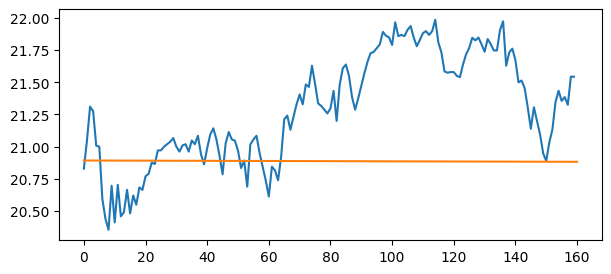

In [156]:
plt.figure(figsize=(7,3))
regression = []

plt.plot(val_y)
print([lin_reg.predict([val_x[0]]), lin_reg.predict([val_x[-1]])])
plt.plot([0, len(val_y)], [lin_reg.predict([val_x[0]]), lin_reg.predict([val_x[-1]])])

# plt.plot(regression, color='red')
plt.show()

In [157]:
start, end = (lin_reg.predict([val_x[0]]), lin_reg.predict([val_x[-1]]))

In [158]:
tan = (end - start) / (val_x[-1][0] - val_x[0][0])
tan

array([0.00671453])

In [159]:
b = end - tan * val_x[0][0]
b

array([20.74102431])

In [160]:
ups, downs = np.zeros(len(val_x[-1])), np.zeros(len(val_x[-1]))
treshold = 1e-2

for idx, x in enumerate(val_x[-1]):
    _x = x * tan + b
    if x - _x > treshold:
        ups[idx] += 1
    elif x - _x <= -treshold:
        downs[idx] += 1

In [161]:
print(ups.sum(), downs.sum())

150.0 97.0


In [162]:
print(f'fitted ratio = {(len(val_x[-1]) - ups.sum() - downs.sum()) / len(val_x[-1])}' +\
      f'\toutfitted ratio = {(ups.sum() + downs.sum()) / len(val_x[-1])}')


fitted ratio = 0.012	outfitted ratio = 0.988


In [163]:
df_to_predict = get_data_markets(ticker=TICKER_NAME, interval=interval, start_date='2022-10-18', end_date=end_date, source='yahoo')
close_prices = df_to_predict['Close'].values

fitted = close_prices * tan + b
residuals = close_prices - fitted
# TODO make points and sen calculate residuals

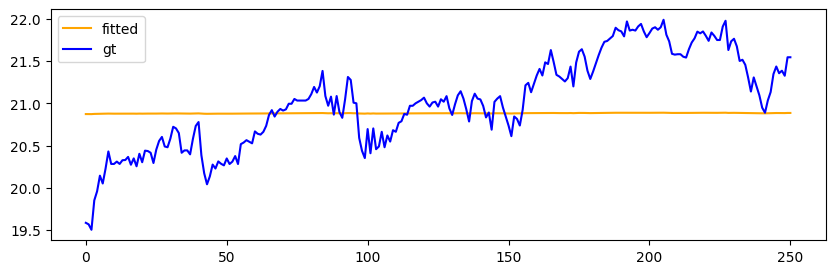

In [164]:
plt.figure(figsize=(10, 3))
plt.plot(fitted, label='fitted', color='orange')
plt.plot(close_prices, label='gt', color='blue')
plt.legend()
plt.show()

## Residuals vs Fitted

<class 'numpy.ndarray'>


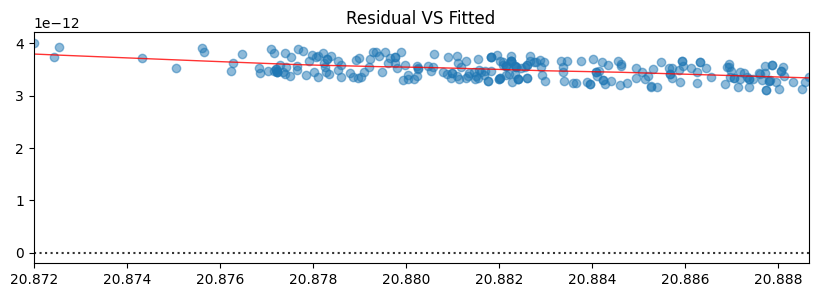

'\nвидим, что очень сильно коррелированы,\nлиния красная средняя линия почти горизонтальная с малым углом наклона\n'

In [165]:
import seaborn as sns

data = {'fitted': fitted, 'gt': close_prices }
print(type(fitted))

plt.figure(figsize=(10,3))
fig = sns.residplot(x='fitted', y='gt', data=data,
                    lowess=True,
                    scatter_kws={'alpha': 0.5},
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}) 
plt.title('Residual VS Fitted')
plt.show()


"""
видим, что очень сильно коррелированы,
линия красная средняя линия почти горизонтальная с малым углом наклона
"""

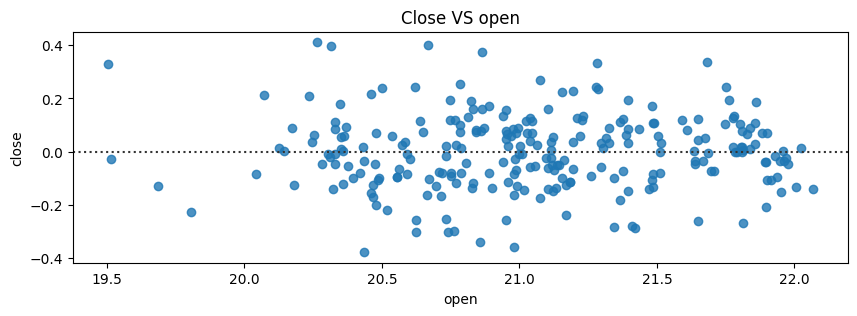

In [166]:
data = {'open': df_to_predict['Open'].values, 'gt': close_prices }

plt.figure(figsize=(10,3))
fig = sns.residplot(x='open', y='gt', data=data) 
plt.title('Close VS open')
plt.xlabel('open')
plt.ylabel('close')
plt.show()

## Normal Q-Q

In [167]:
import statsmodels.api as sm

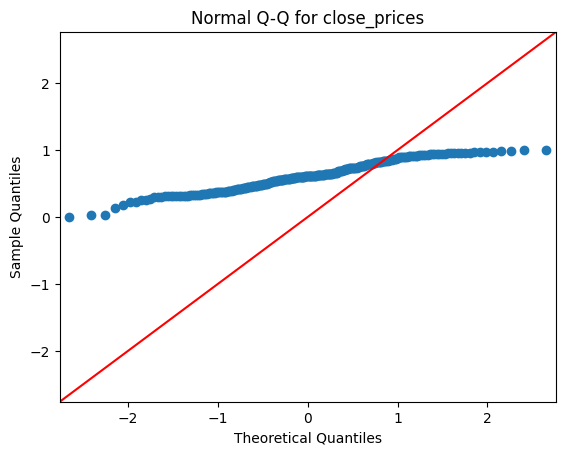

'\n    Чем лучше точки ложатся на красную линию, тем распределение точек остатков более \n    похоже на нормальное, но здесь видим, что линия точек немного отклонена от горизонтали,\n    значит распределение цен закрытия временного ряда слабо похоже на нормальное\n'

In [168]:
fig = sm.qqplot((fitted - np.min(fitted)) / (np.max(fitted) - np.min(fitted)), line='45')
plt.title('Normal Q-Q for close_prices')
plt.show()

"""
    Чем лучше точки ложатся на красную линию, тем распределение точек остатков более 
    похоже на нормальное, но здесь видим, что линия точек немного отклонена от горизонтали,
    значит распределение цен закрытия временного ряда слабо похоже на нормальное
"""

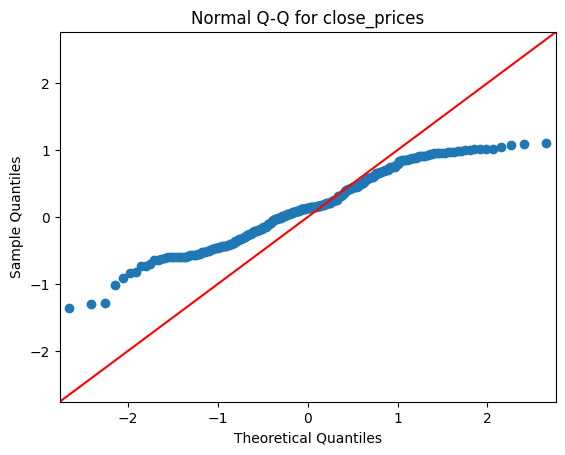

'\n    Чем лучше точки ложатся на красную линию, тем распределение точек остатков более \n    похоже на нормальное, но здесь видим, что линия точек немного отклонена от диагональной линии,\n    значит распределение остатков похоже на нормальное\n'

In [169]:
fig = sm.qqplot(close_prices - fitted, line='45')
plt.title('Normal Q-Q for close_prices')
plt.show()

"""
    Чем лучше точки ложатся на красную линию, тем распределение точек остатков более 
    похоже на нормальное, но здесь видим, что линия точек немного отклонена от диагональной линии,
    значит распределение остатков похоже на нормальное
"""

## Scale-Location

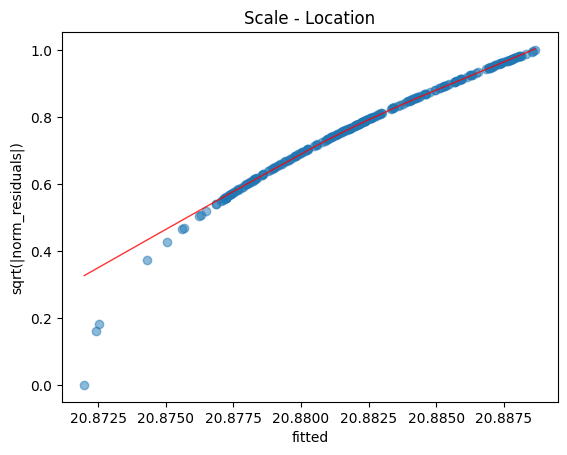

In [170]:
residuals = close_prices - fitted
norm_abs_sqrt_residuals = np.sqrt(np.abs((residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals))))

fig = plt.figure()
plt.scatter(fitted, norm_abs_sqrt_residuals, alpha=0.5)

data_to_plot = {'fitted': fitted, 'norm_resid': norm_abs_sqrt_residuals}
sns.regplot(data=data_to_plot, x='fitted', y='norm_resid',
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

indexes = np.argsort(norm_abs_sqrt_residuals)
_fitted = fitted[sorted_indexes]
_residuals = norm_abs_sqrt_residuals[indexes]

plt.xlabel('fitted')
plt.ylabel('sqrt(|norm_residuals|)')
plt.title('Scale - Location')

# plt.legend()
plt.show()

# for (f, r) in zip(_fitted, _residuals):
#     plt.plot(f, r, 'bo')

## Residuals vs Leverage

'\n    В нашей моделе не наблюдается выбросов\n'

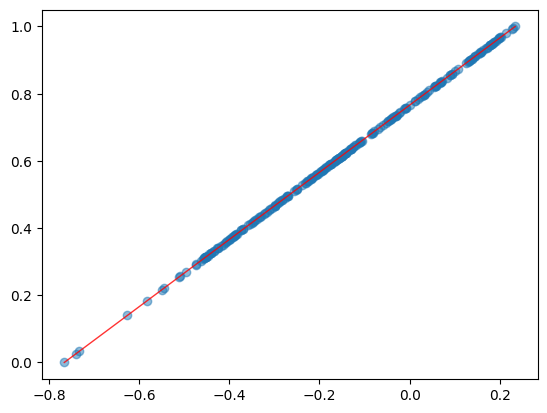

In [177]:
residuals = close_prices - fitted

norm_residuals = np.abs((residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals)))

X = np.expand_dims(norm_residuals, 0)

leverage = norm_residuals - norm_abs_sqrt_residuals.mean()

plt.scatter(leverage, norm_residuals, alpha=0.5)

data = {'leverage': leverage, 'norm_res': norm_residuals}
sns.regplot(data=data, x='leverage', y='norm_res',
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

"""
    В нашей моделе не наблюдается выбросов
"""

# Period = 50 days

In [178]:
period = 50

train_x, train_y, val_x, val_y = get_training_and_validation_samples(df, period)

In [179]:
lin_reg = LinearRegression().fit(train_x, train_y)
prediction = lin_reg.predict(val_x)

[array([20.90111139]), array([21.31941898])]


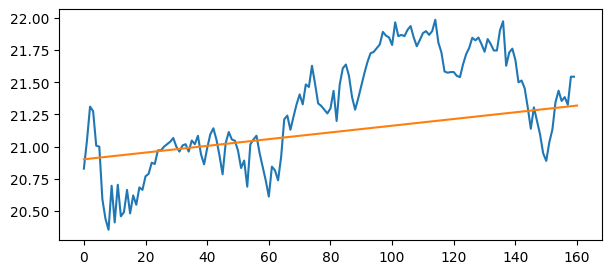

In [180]:
plt.figure(figsize=(7,3))
regression = []

plt.plot(val_y)
print([lin_reg.predict([val_x[0]]), lin_reg.predict([val_x[-1]])])
plt.plot([0, len(val_y)], [lin_reg.predict([val_x[0]]), lin_reg.predict([val_x[-1]])])

# plt.plot(regression, color='red')
plt.show()

In [181]:
start, end = (lin_reg.predict([val_x[0]]), lin_reg.predict([val_x[-1]]))
tan = (end - start) / (val_x[-1][0] - val_x[0][0])
b = end - tan * val_x[0][0]


tan, b

(array([0.41708169]), array([12.65319057]))

In [182]:
df_to_predict = get_data_markets(ticker=TICKER_NAME, interval=interval, start_date='2022-10-18', end_date=end_date, source='yahoo')
close_prices = df_to_predict['Close'].values

fitted = close_prices * tan + b
residuals = close_prices - fitted

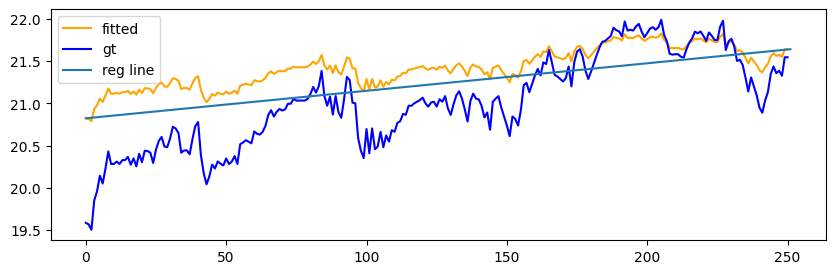

In [187]:
plt.figure(figsize=(10, 3))
plt.plot(fitted, label='fitted', color='orange')
plt.plot(close_prices, label='gt', color='blue')
plt.plot([0, len(close_prices)], [fitted[0], fitted[-1]], label='reg line')
plt.legend()
plt.show()

## 95% доверительный интервал

In [204]:
expected_stat_pred = fitted.mean()
expected_stat_gt = close_prices.mean()
dispertion_stat_gt = (np.sum(close_prices**2) / len(close_prices) - \
                      (close_prices.sum() / len(close_prices)) ** 2) * len(close_prices) / (len(close_prices) - 1)

Phi_0_95 = 1.65
Phi_0_05 = 0.065

left_border = expected_stat_pred - dispertion_stat_gt / np.sqrt(len(close_prices)) * Phi_0_95# Phi_0_05
right_border = expected_stat_pred + dispertion_stat_gt / np.sqrt(len(close_prices)) * Phi_0_95 # Phi_0_05

print('Доверительный интервал = ')
print(left_border, right_border)

Доверительный интервал = 
21.389902696599925 21.450601721841892


# Residual vs Fitted

<class 'numpy.ndarray'>


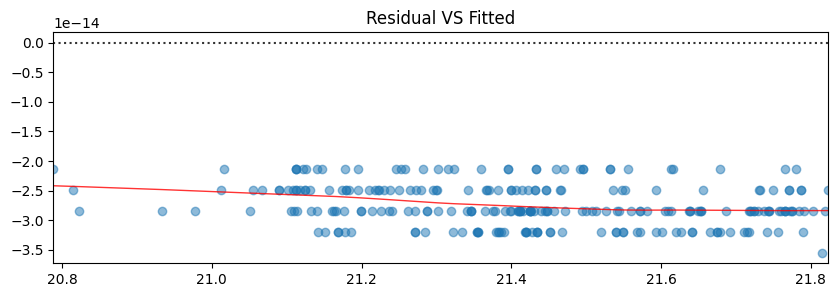

'\nвидим, что очень сильно коррелированы,\nлиния красная средняя линия почти горизонтальная с малым углом наклона\n'

In [188]:
import seaborn as sns

data = {'fitted': fitted, 'gt': close_prices }
print(type(fitted))

plt.figure(figsize=(10,3))
fig = sns.residplot(x='fitted', y='gt', data=data,
                    lowess=True,
                    scatter_kws={'alpha': 0.5},
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}) 
plt.title('Residual VS Fitted')
plt.show()


"""
видим, что очень сильно коррелированы,
линия красная средняя линия почти горизонтальная с малым углом наклона
"""

## Normal Q-Q

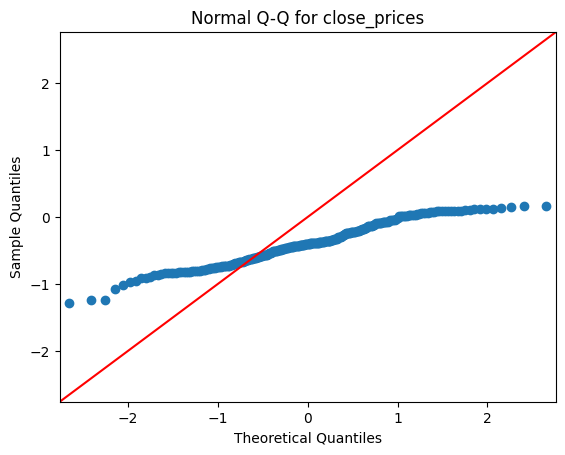

'\n    Чем лучше точки ложатся на красную линию, тем распределение точек остатков более \n    похоже на нормальное, но здесь видим, что линия точек немного отклонена от диагональной линии,\n    значит распределение остатков слабо похоже на нормальное\n'

In [190]:
fig = sm.qqplot(close_prices - fitted, line='45')
plt.title('Normal Q-Q for close_prices')
plt.show()

"""
    Чем лучше точки ложатся на красную линию, тем распределение точек остатков более 
    похоже на нормальное, но здесь видим, что линия точек немного отклонена от диагональной линии,
    значит распределение остатков слабо похоже на нормальное
"""

## Scale-Location

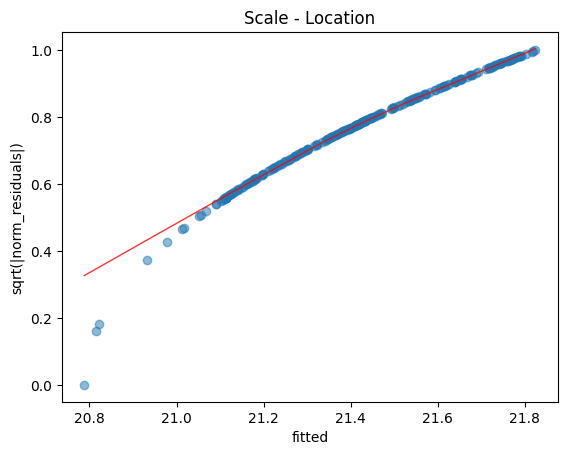

'\n В самом начале есть сильные отклонения, потом скорость роста выровнялась\n'

In [192]:
residuals = close_prices - fitted
norm_abs_sqrt_residuals = np.sqrt(np.abs((residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals))))

fig = plt.figure()
plt.scatter(fitted, norm_abs_sqrt_residuals, alpha=0.5)

data_to_plot = {'fitted': fitted, 'norm_resid': norm_abs_sqrt_residuals}
sns.regplot(data=data_to_plot, x='fitted', y='norm_resid',
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

indexes = np.argsort(norm_abs_sqrt_residuals)
_fitted = fitted[sorted_indexes]
_residuals = norm_abs_sqrt_residuals[indexes]

plt.xlabel('fitted')
plt.ylabel('sqrt(|norm_residuals|)')
plt.title('Scale - Location')

plt.show()

"""
 В самом начале есть сильные отклонения, потом скорость роста выровнялась
"""

## Residuals vs Leverage

'\n    В нашей моделе сильных выбросов не наблюдается не наблюдается выбросов\n'

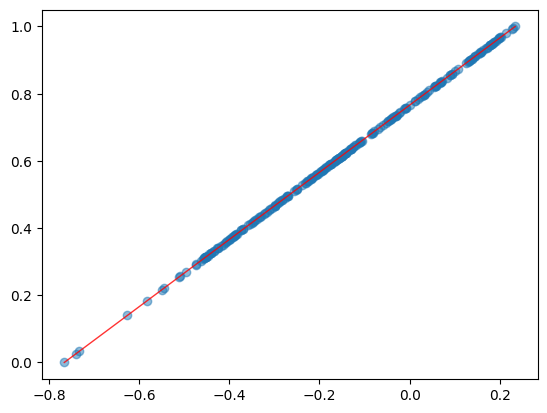

In [194]:
residuals = close_prices - fitted

norm_residuals = np.abs((residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals)))

X = np.expand_dims(norm_residuals, 0)

leverage = norm_residuals - norm_abs_sqrt_residuals.mean()

plt.scatter(leverage, norm_residuals, alpha=0.5)

data = {'leverage': leverage, 'norm_res': norm_residuals}
sns.regplot(data=data, x='leverage', y='norm_res',
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

"""
    В нашей моделе сильных выбросов не наблюдается не наблюдается выбросов
"""